# Goals for AIGAME - RPS (Rock, Paper, Scissors) Part 6

In part 5
* We looked at a sample Iris dataset
* We explored methods for viewing/analyzing that data
* We applied a Decision Tree machine learning algorithm to determine the type of Iris based on measurements on the flower
* Finally we tried to apply a Decision Tree to predicting the outcome of a RPS game.

But we are not interestd in determining the outcome of a Rock Paper Scissors game. We already know how to do that and so we don't need AI help. Rather we want the AI to play the game for us, to choose whether the AI should choose Rock, Paper or Scissors.

### Does it make sense for an AI to play Rock, Paper, Scissors?
I know, I know. You might be saying that it makes no sense for an AI to play this game because, in theory, the game is totally random, like flipping a coin.

In theory it should be, but it's not in practice. For example, I tend to choose ROCK. When I played the AI, I choose ROCK whenever I am unsure what to play. Also, if the AI beats me with the same choice twice in a row, I tend to assume it will continue to play that way.

Most people have patterns to their play and that is what the AI can learn. In my case, it should learn that I tend to prefer ROCK and hence it should prefer PAPER since PAPER beats/covers ROCK

We saw in the Iris dataset that measurements of the width and length of the sepal and petal of an Iris flow is useful in determining the type of Iris flower (target).

So what information would our AI want? Let's brainstorm:
* Percent of game history that the human chose ROCK
* Percent of game history that the human chose PAPER
* What did the human play last?
* What was the last outcome?

### Goal - we want to create a dataset which the AI can actually use



In [3]:
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split


# Build Experience - how to choose useful feature data

### Let's use the following data (features) for our RPS AI:
1.  Human response for the last 3 games (3 values)
1.  AI response for the last 3 games (3 values)
1.  Outcome for the last 3 games
1.  % Human chooses Rock in last 10 games
1.  % Human chooses Paper in last 10 games
1.  % Human chooses Scissors in last 10 games
1.  % Human chooses Rock in last 30 games
1.  % Human chooses Paper in last 30 games
1.  % Human chooses Scissors in last 30 games

### Let's create a dataframe which holds the above information

In [4]:
# Let's make a function which enters the above information into a DataFrame 
def addToRPSDataDS(ds, hL1,hL2,hL3,aiL1,aiL2,aiL3,outcome1,outcome2,outcome3,pctHumanRock10,pctHumanPaper10,pctHumanScissors10, 
                  pctHumanRock30, pctHumanPaper30, pctHumanScissors30, aiWinningMove):
    newval = {'HumanL1':[1], 'HumanL2':[hL2], 'HumanL3':[hL3], 'AIL1':[aiL1],'AIL2':[aiL2],'AIL3':[aiL3],'Outcome1':[outcome1], 'Outcome2':[outcome2],
             'Outcome3':[outcome3], 'PctHumanRock10': [pctHumanRock10], 'PctHumanPaper10': [pctHumanPaper10], 
              'PctHumanScissors10': [pctHumanScissors10], 'PctHumanRock30': [pctHumanRock30], 'PctHumanPaper30': [pctHumanPaper30], 
              'PctHumanScissors30': [pctHumanScissors30], 'AIWinningMove':[aiWinningMove]}
    retvalue = ds
    if (ds is None):
        retvalue = pd.DataFrame(newval)
    else:
        ds.loc[len(ds.index)] = [hL1,hL2,hL3,aiL1,aiL2,aiL3,outcome1,outcome2,outcome3,pctHumanRock10,pctHumanPaper10,
                                pctHumanScissors10,pctHumanRock30, pctHumanPaper30,pctHumanScissors30, aiWinningMove]
    return retvalue

In [5]:
# Let's test it out with some sample data
dsRPSData = addToRPSDataDS(None, 1,2,3,2,3,1,1,1,1,2.0,2.0,2.0,3.0,2.0,3.4,1)

dsHold = dsRPSData
dsRPSData = addToRPSDataDS(dsRPSData, 2,3,4,6,3,1,1,1,1,2.0,2.0,2.0,3.0,2.0,3.4,1)
print( dsHold is dsRPSData)
print(dsRPSData)



True
   HumanL1  HumanL2  HumanL3  AIL1  AIL2  AIL3  Outcome1  Outcome2  Outcome3  \
0      1.0      2.0      3.0   2.0   3.0   1.0       1.0       1.0       1.0   
1      2.0      3.0      4.0   6.0   3.0   1.0       1.0       1.0       1.0   

   PctHumanRock10  PctHumanPaper10  PctHumanScissors10  PctHumanRock30  \
0             2.0              2.0                 2.0             3.0   
1             2.0              2.0                 2.0             3.0   

   PctHumanPaper30  PctHumanScissors30  AIWinningMove  
0              2.0                 3.4            1.0  
1              2.0                 3.4            1.0  


### Now we want to use game history to create the above quantities.
We know how to get the last Human response and the second to last Human response...

Similar for AI responses

And, similarly, we can get the last game outcome and the one before that and the one before that.

But how do we get the percent of the time the user selected ROCK over the last 10 games. This is a running  number which will change as each game is added. How do we get that?

### Remember when we talked about classes? And how we weren't going to use them? 

Fooled you, let's use them to calculate running averages.

In [6]:
class RunningAverage:
    def __init__(self, windowSize, minPoints, defaultValue):
        self.windowSize = windowSize
        self.minPoints = minPoints
        self.defaultValue = defaultValue
        self.values = [] #empty array
    def addToRunningAverage(self,val):
        self.values.insert(0,val)
        if len(self.values) > self.windowSize:
            self.values.pop()
    def getRunningAverage(self):
        print(len(self.values))
        if len(self.values) == 0:
            return None
        elif len(self.values) < self.minPoints:
            return self.defaultValue
        else:
            series1 = pd.Series(data=self.values)
            retvalue = series1.mean()
            return retvalue
            
    


In [7]:
# Let's test out the above function
ave10 = RunningAverage(windowSize=10, minPoints=3, defaultValue=0.33333)
print(ave10.getRunningAverage())
ave10.addToRunningAverage(1.0)
print(ave10.getRunningAverage())
ave10.addToRunningAverage(2.0)
print(ave10.getRunningAverage())
ave10.addToRunningAverage(1.0)
print(ave10.getRunningAverage())
ave10.addToRunningAverage(2.0)
print(ave10.getRunningAverage())


0
None
1
0.33333
2
0.33333
3
1.3333333333333333
4
1.5


# Revisit: Feature vs Target
As we discussed before, the 'Target' is the value which the AI is trying to determine. The 'Feature Data' is the data which it can use to do so.
In the case of Iris flowers, the 'Feature Data' was the length and width of the sepal and petal of the flower. The 'Target' was the type of Iris.

For RPS, we discussed the feature data above. What is the target? Well, since the AI is playing the game, the 'Target' is the winning move, a selection of Rock, Paper or Scissors which will beat the human's choice (on average).

So let's create a function which determins the 'Target'

In [9]:
###################
# Rock, Paper or Scissors
ROCK=1
PAPER=2
SCISSORS=3
#AI Win, Human Win or DRAW
DRAW=0
AI_WIN=1
HUMAN_WIN=-1
#####################################
def DetermineAIWinningMove(humanResponse):
    if humanResponse == ROCK:
        return PAPER # PAPER beats ROCK
    elif humanResponse == PAPER:
        return SCISSORS #SCISSORS beats/cuts PAPER
    else:
        return ROCK #ROCK breaks scissors

In [10]:
#Let's test it out
print('If human chooses ROCK, then AI should choose', DetermineAIWinningMove(ROCK))
print('If human chooses PAPER, then AI should choose', DetermineAIWinningMove(PAPER))
print('If human chooses SCISSORS, then AI should choose', DetermineAIWinningMove(SCISSORS))

If human chooses ROCK, then AI should choose 2
If human chooses PAPER, then AI should choose 3
If human chooses SCISSORS, then AI should choose 1


# Execute
We will now read the game history and turn it into something we can input to our AI: a DataFrame which represents game history statistics including running averages and recent plays.

In [22]:
RPS_RESULTS_PATH = 'C:/Users/LEN320/Google Drive/DEV/Python/rps_results.xls'
def LoadGameResults(fileLoadPath):
    '''This function takes one argument (the path of the saved results) and returns a DataFrame'''
    retvalue = pd.read_excel(fileLoadPath, sheet_name="RPS Results")
    return retvalue

dsResults = LoadGameResults(RPS_RESULTS_PATH)
dsRPSData = None 
pctHumanRock10 = RunningAverage(windowSize=10, minPoints=5, defaultValue=0.33333)
pctHumanPaper10 = RunningAverage(windowSize=10, minPoints=5, defaultValue=0.33333)
pctHumanScissors10 = RunningAverage(windowSize=10, minPoints=5, defaultValue=0.33333)
pctHumanRock30 = RunningAverage(windowSize=30, minPoints=5, defaultValue=0.33333)
pctHumanPaper30 = RunningAverage(windowSize=30, minPoints=5, defaultValue=0.33333)
pctHumanScissors30 = RunningAverage(windowSize=30, minPoints=5, defaultValue=0.33333)
HumanL2 = HumanL3 = AIL2 = AIL3 = 1 #default to rock
LastAIMove = LastHumanMove = HumanL1 = AIL1 = 1 # default all to ROCK
LastOutcome = Outcome2 = Outcome3 = Outcome1 =  0 #draw
for i in dsResults.index:
    #Data for this round, note that we will NOT store the Human or AI move for this round, only AIWinningMove (Target)
    ThisHumanMove = dsResults.at[i,'Human Response']
    ThisAIMove = dsResults.at[i,'AI Response'] 
    ThisOutcome = dsResults.at[i,'Outcome']
    AIWinner = DetermineAIWinningMove(ThisHumanMove)
    
    
    #Update history for last 3 moves
    HumanL3 = HumanL2
    HumanL2 = HumanL1
    HumanL1 = LastHumanMove
    AIL3 = AIL2
    AIL2 = AIL1
    AIL1 = LastAIMove   
    Outcome3 = Outcome2
    Outcome2 = Outcome1   
    Outcome1 = LastOutcome
    
    #Update running averages for the last round
    pctHumanRock10.addToRunningAverage(1.0 if HumanL1==1 else 0.0)
    pctHumanPaper10.addToRunningAverage(1.0 if HumanL1==2 else 0.0)
    pctHumanScissors10.addToRunningAverage(1.0 if HumanL1==3 else 0.0)

    pctHumanRock30.addToRunningAverage(1.0 if HumanL1==1 else 0.0)
    pctHumanPaper30.addToRunningAverage(1.0 if HumanL1==2 else 0.0)
    pctHumanScissors30.addToRunningAverage(1.0 if HumanL1==3 else 0.0)  
    
    #Update last move
    LastAIMove = ThisAIMove
    LastHumanMove = ThisHumanMove
    LastOutcome = ThisOutcome
    
    #Fill the data frame, note that we record the AI Winning Move because that is the target. But the rest is historical. 
    #We want the AI to choose based on history only
  
    
    #print('winning move on', HumanL1,'is',AIWinner, 'Rock10Human=',pctHumanRock10.getRunningAverage())
    dsRPSData = addToRPSDataDS(dsRPSData, HumanL1, HumanL2, HumanL3, AIL1, AIL2, AIL3, Outcome1, Outcome2, Outcome3,
                               pctHumanRock10.getRunningAverage(), pctHumanPaper10.getRunningAverage(), pctHumanScissors10.getRunningAverage(),
                               pctHumanRock30.getRunningAverage(), pctHumanPaper30.getRunningAverage(), pctHumanScissors30.getRunningAverage(),
                              AIWinner)

1
1
1
1
1
1
2
2
2
2
2
2
3
3
3
3
3
3
4
4
4
4
4
4
5
5
5
5
5
5
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
10
10
10
11
11
11
10
10
10
12
12
12
10
10
10
13
13
13
10
10
10
14
14
14
10
10
10
15
15
15
10
10
10
16
16
16
10
10
10
17
17
17
10
10
10
18
18
18
10
10
10
19
19
19
10
10
10
20
20
20
10
10
10
21
21
21
10
10
10
22
22
22
10
10
10
23
23
23
10
10
10
24
24
24
10
10
10
25
25
25
10
10
10
26
26
26
10
10
10
27
27
27
10
10
10
28
28
28
10
10
10
29
29
29
10
10
10
30
30
30
10
10
10
30
30
30
10
10
10
30
30
30
10
10
10
30
30
30


In [23]:
dsRPSData.describe()

,HumanL1,HumanL2,HumanL3,AIL1,AIL2,AIL3,Outcome1,Outcome2,Outcome3,PctHumanRock10,PctHumanPaper10,PctHumanScissors10,PctHumanRock30,PctHumanPaper30,PctHumanScissors30,AIWinningMove
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,1.575758,1.515152,1.515152,2.000000,1.969697,1.939394,0.151515,0.181818,0.151515,0.593566,0.232696,0.173737,0.660832,0.215487,0.123680,2.000000
std,0.791766,0.755034,0.755034,0.829156,0.847233,0.863836,0.755034,0.726918,0.712444,0.190619,0.073683,0.142340,0.155791,0.057765,0.105153,0.661438
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,0.333330,0.100000,0.000000,0.333330,0.100000,0.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.400000,0.200000,0.000000,0.608696,0.190476,0.000000,2.000000
50%,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.600000,0.200000,0.200000,0.650000,0.214286,0.137931,2.000000
75%,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,1.000000,1.000000,1.000000,0.800000,0.300000,0.300000,0.769231,0.233333,0.166667,2.000000
max,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,1.000000,1.000000,1.000000,0.900000,0.333330,0.400000,0.900000,0.333330,0.333330,3.000000


We have created a DataFrame that holds both our 'Target' (Winning move for AI) and all of the 'Feature Data' which we thought might be useful in determining the Target. Let's explorer the data a bit.

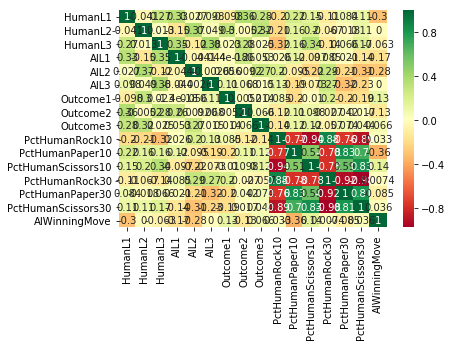

In [24]:
# We show a heat map (or correlation map) for the data in the DataFrame we just created.
# You can see what values are correlated to each other. Of special interest is data that is correlated
# with our target (AIWinningMove). If we needed to reduce the amount of input data, we could use this map
# to guide our choices. But for now we leave it all.
import seaborn as sns
correlation = dsRPSData.corr()
#plt.style.use("ggplot")
sns.heatmap(correlation, annot=True, cbar=True, cmap="RdYlGn")

Heatmap's are an interesting way to view correlations between data fields, but it is too cluttered for us to see. Let's only look at correlations with our target:
    

In [25]:
correlation.AIWinningMove

HumanL1              -0.298355
HumanL2               0.000000
HumanL3              -0.062574
AIL1                 -0.170941
AIL2                 -0.278823
AIL3                  0.000000
Outcome1              0.125148
Outcome2             -0.129989
Outcome3              0.066315
PctHumanRock10        0.033046
PctHumanPaper10      -0.363350
PctHumanScissors10    0.143831
PctHumanRock30        0.007350
PctHumanPaper30      -0.084914
PctHumanScissors30    0.035752
AIWinningMove         1.000000
Name: AIWinningMove, dtype: float64

None of the fields are stringly correlated with the winning move. That makes sense else it would be easy for the AI to choose a winning move.


Let's see how the Decision Tree algorithm does with the data.

In [26]:
Target = dsRPSData['AIWinningMove'] #This is what the AI needs to determine: the winning move
Features = dsRPSData.drop(['AIWinningMove'], axis=1) #This is the data which can be used to learn the winning move.
#Note we remove AIWinningMove column as that is the answer and Features should not include the answer
Features.describe()

,HumanL1,HumanL2,HumanL3,AIL1,AIL2,AIL3,Outcome1,Outcome2,Outcome3,PctHumanRock10,PctHumanPaper10,PctHumanScissors10,PctHumanRock30,PctHumanPaper30,PctHumanScissors30
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,1.575758,1.515152,1.515152,2.000000,1.969697,1.939394,0.151515,0.181818,0.151515,0.593566,0.232696,0.173737,0.660832,0.215487,0.123680
std,0.791766,0.755034,0.755034,0.829156,0.847233,0.863836,0.755034,0.726918,0.712444,0.190619,0.073683,0.142340,0.155791,0.057765,0.105153
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,0.333330,0.100000,0.000000,0.333330,0.100000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.400000,0.200000,0.000000,0.608696,0.190476,0.000000
50%,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.600000,0.200000,0.200000,0.650000,0.214286,0.137931
75%,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,1.000000,1.000000,1.000000,0.800000,0.300000,0.300000,0.769231,0.233333,0.166667
max,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,1.000000,1.000000,1.000000,0.900000,0.333330,0.400000,0.900000,0.333330,0.333330


In [27]:
print(Target[0:4])
Features[0:4]

0    3.0
1    2.0
2    2.0
3    2.0
Name: AIWinningMove, dtype: float64


,HumanL1,HumanL2,HumanL3,AIL1,AIL2,AIL3,Outcome1,Outcome2,Outcome3,PctHumanRock10,PctHumanPaper10,PctHumanScissors10,PctHumanRock30,PctHumanPaper30,PctHumanScissors30
0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.33333,0.33333,0.33333,0.33333,0.33333,0.33333
1,2.0,1.0,1.0,1.0,1.0,1.0,-1.0,0.0,0.0,0.33333,0.33333,0.33333,0.33333,0.33333,0.33333
2,1.0,2.0,1.0,1.0,1.0,1.0,0.0,-1.0,0.0,0.33333,0.33333,0.33333,0.33333,0.33333,0.33333
3,1.0,1.0,2.0,3.0,1.0,1.0,-1.0,0.0,-1.0,0.33333,0.33333,0.33333,0.33333,0.33333,0.33333


In [28]:
#As before, split the data in a training set and a test set. We will use 80% of the data for training.
X_train, X_test, y_train, y_test = train_test_split(Features, Target, test_size=0.20, shuffle=False)
X_train.shape

(26, 15)

In [29]:
#Create the DecisionTree and train it on the training data
clf = DecisionTreeClassifier(random_state=0)
results = clf.fit(X_train,y_train)


In [30]:
#Let's determine the score (the fraction of time the AI chose the correct move)
results.score(X_test,y_test)

0.2857142857142857

###  When I ran this, I got a score of 0.29 or 29%. This is not good because random guessing should get a score of 1/3 or 33%. Let's see what would happen if we applied the score to the training set.


In [32]:
results.score(X_train,y_train)

1.0

### Hmm, so the algorithm got a 100% on the training data but only 29% on the test data. I have made a populare AI mistake. But let's talk about that next time. Let's see what the Decision Tree is doing.

Remember we said that a Decision Tree has a set of rules, much like the game of 20 questions? So we can ask it to tell us those rules. This sets it apart from some other machine learning algorithms where it is much harder to tell what the algorithm is doing.

In [33]:
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print( "{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)

In [28]:
tree_to_code(results, feature_names=Features.columns)

def tree(HumanL1, HumanL2, HumanL3, AIL1, AIL2, AIL3, Outcome1, Outcome2, Outcome3, PctHumanRock10, PctHumanPaper10, PctHumanScissors10, PctHumanRock30, PctHumanPaper30, PctHumanScissors30):
  if HumanL1 <= 1.5:
    if PctHumanScissors30 <= 0.28735464811325073:
      return [[0. 9. 0.]]
    else:  # if PctHumanScissors30 > 0.28735464811325073
      if Outcome3 <= -0.5:
        return [[0. 1. 0.]]
      else:  # if Outcome3 > -0.5
        if HumanL2 <= 1.5:
          return [[0. 0. 1.]]
        else:  # if HumanL2 > 1.5
          return [[0. 1. 0.]]
  else:  # if HumanL1 > 1.5
    if HumanL1 <= 2.5:
      return [[ 0.  0. 12.]]
    else:  # if HumanL1 > 2.5
      return [[8. 0. 0.]]


In [ ]:
### We'll talk about this more next time